In [1]:
import tifffile as tiff
import numpy as np
from dbfread import DBF
from matplotlib import pyplot
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, concatenate, Dropout, Input, Reshape,BatchNormalization, MaxPooling2D, UpSampling2D, ReLU, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
#look at labels
for record in DBF('CDL_2013_clip_20170525181724_1012622514.tif.vat.dbf'):
    if 'Corn' in record['CLASS_NAME']:
        print(record)
    if 'Soybean' in record['CLASS_NAME']:
        print(record)

OrderedDict([('VALUE', 1), ('CLASS_NAME', 'Corn'), ('RED', 1.0), ('GREEN', 0.82745098039), ('BLUE', 0.0), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 5), ('CLASS_NAME', 'Soybeans'), ('RED', 0.14901960784), ('GREEN', 0.43921568628), ('BLUE', 0.0), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 12), ('CLASS_NAME', 'Sweet Corn'), ('RED', 0.86666666667), ('GREEN', 0.64705882353), ('BLUE', 0.04705882353), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 13), ('CLASS_NAME', 'Pop or Orn Corn'), ('RED', 0.86666666667), ('GREEN', 0.64705882353), ('BLUE', 0.04705882353), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 26), ('CLASS_NAME', 'Dbl Crop WinWht/Soybeans'), ('RED', 0.43921568628), ('GREEN', 0.43921568628), ('BLUE', 0.0), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 225), ('CLASS_NAME', 'Dbl Crop WinWht/Corn'), ('RED', 1.0), ('GREEN', 0.82745098039), ('BLUE', 0.0), ('OPACITY', 1.0)])
OrderedDict([('VALUE', 226), ('CLASS_NAME', 'Dbl Crop Oats/Corn'), ('RED', 1.0), ('GREEN', 0.82745098039), ('BLUE', 0.0), ('OPAC

In [3]:
# Using 3 classes
# Labels like 'Sweet corn' are classified as other b/c of insignificant presence
# just as a reminder
classname = {
    0: 'corn',
    1: 'soybeans',
    2: 'other'
}

In [4]:
# load data and label
label = tiff.imread('CDL_2013_Champaign_north.tif')
data = tiff.imread('20130824_RE3_3A_Analytic_Champaign_north.tif')
print(label.shape)
print(data.shape)

# reformat label into 3 classes
print(np.unique(label, return_counts=True))
label[label == 1] = 0
label[label == 5] = 1
label[label > 1] = 2
print(np.unique(label, return_counts=True))

(5959, 9425)
(5959, 9425, 5)
(array([  1,   4,   5,  12,  13,  24,  26,  27,  28,  36,  37,  43,  58,
        59,  61, 111, 121, 122, 123, 124, 131, 141, 152, 176, 190, 195,
       222, 225, 241, 254], dtype=uint8), array([25320079,       91, 21417646,       49,      175,   347273,
          11531,       98,     5822,    80493,    74592,     3319,
            570,      406,     2299,   154704,  2325753,  1977922,
         375668,   124415,    23416,  1287172,      680,  2522307,
         105601,      680,      189,      176,      407,       42],
      dtype=int64))
(array([0, 1, 2], dtype=uint8), array([25320079, 21417646,  9425850], dtype=int64))


In [5]:
# reformat into 128*128, vectorized
h, w, _ = data.shape
h = int(h/128)
w = int(w/128)
x_train = data[:h * 128, :w * 128, :]
y_train = label[:h * 128, :w * 128]

x_train = np.reshape(x_train, (h, 128, w, 128, 5))
x_train = np.transpose(x_train, axes=(0,2,1,3,4))
x_train = np.reshape(x_train, (-1, 128, 128, 5))

y_train = np.reshape(y_train, (h, 128, w, 128))
y_train = np.transpose(y_train, axes=(0,2,1,3))
y_train = np.reshape(y_train, (-1, 128, 128))

#sanity check
print(int(label.shape[0]/128) * int(label.shape[1]/128))
print(x_train.shape)
print(y_train.shape)

3358
(3358, 128, 128, 5)
(3358, 128, 128)


In [8]:
#drop training entry with all 0s (approximatly 200 img)
x_cleaned = [x for x, y in zip(x_train,y_train) if x.any() != 0]
y_cleaned = [y for x, y in zip(x_train,y_train) if x.any() != 0]
X = np.array(x_cleaned)
y = np.array(y_cleaned)

#train test split
arr_rand = np.random.rand(X.shape[0])
split = arr_rand < np.percentile(arr_rand, 90)

x_train = X[split]
y_train = y[split]
x_test =  X[~split]
y_test = y[~split]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(2993, 128, 128, 5) (2993, 128, 128) (333, 128, 128, 5) (333, 128, 128)


In [9]:

# unet model
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = ReLU()(x)
    
    return x

def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = Model(input_img, outputs)
    model.summary()
    return model

In [10]:
input_img = Input((128, 128, 5), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 5) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 736         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [11]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
]

In [12]:
model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    validation_data = [x_test, y_test],
    callbacks = callbacks
)

Train on 2993 samples, validate on 333 samples
Epoch 1/50
2993/2993 [==============================] - 45s 15ms/sample - loss: 0.5549 - accuracy: 0.8054 - val_loss: 1.2364 - val_accuracy: 0.5107
Epoch 2/50
2993/2993 [==============================] - 35s 12ms/sample - loss: 0.3793 - accuracy: 0.8595 - val_loss: 3.0796 - val_accuracy: 0.4683
Epoch 3/50
2993/2993 [==============================] - 35s 12ms/sample - loss: 0.3472 - accuracy: 0.8700 - val_loss: 0.4943 - val_accuracy: 0.8022
Epoch 4/50
2993/2993 [==============================] - 35s 12ms/sample - loss: 0.3264 - accuracy: 0.8769 - val_loss: 0.6159 - val_accuracy: 0.7274
Epoch 5/50
2993/2993 [==============================] - 35s 12ms/sample - loss: 0.3154 - accuracy: 0.8807 - val_loss: 1.2381 - val_accuracy: 0.5705
Epoch 6/50
2993/2993 [==============================] - 35s 12ms/sample - loss: 0.3140 - accuracy: 0.8812 - val_loss: 0.4041 - val_accuracy: 0.8452
Epoch 7/50
2993/2993 [==============================] - 35s 12ms/

In [34]:
from sklearn import metrics

In [38]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=3).flatten()

# use a confusion matrix to see evaluation scores
evaluation_metric = metrics.confusion_matrix(y_test.flatten(), y_pred)
print(metrics.classification_report(y_test.flatten(), y_pred, digits=3))

precision    recall  f1-score   support

           0      0.898     0.927     0.913   2353217
           1      0.918     0.930     0.924   2248811
           2      0.858     0.751     0.801    853844

    accuracy                          0.901   5455872
   macro avg      0.891     0.870     0.879   5455872
weighted avg      0.900     0.901     0.900   5455872



In [43]:
# calculate per class accuracy
accuracy = np.zeros_like(evaluation_metric, dtype=float)
print(evaluation_metric)
accuracy[0] = evaluation_metric[0] / np.sum(evaluation_metric[0])
accuracy[1] = evaluation_metric[1] / np.sum(evaluation_metric[1])
accuracy[2] = evaluation_metric[2] / np.sum(evaluation_metric[2])
print(accuracy)

[[2182329  104829   66059]
 [ 115933 2092435   40443]
 [ 131211   81683  640950]]
[[0.92738111 0.0445471  0.02807178]
 [0.05155302 0.93046281 0.01798417]
 [0.15367093 0.09566502 0.75066406]]


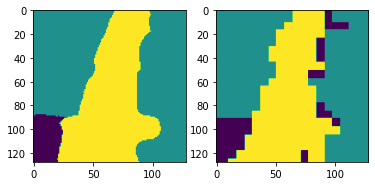

In [19]:
# have model predict an image
# looks ok, the edge is not every clear
out = model.predict(x_test[66:67])
out = np.argmax(out[0], axis=2)
pyplot.subplot(1,2,1)
pyplot.imshow(out)
pyplot.subplot(1,2,2)
pyplot.imshow(y_test[66])

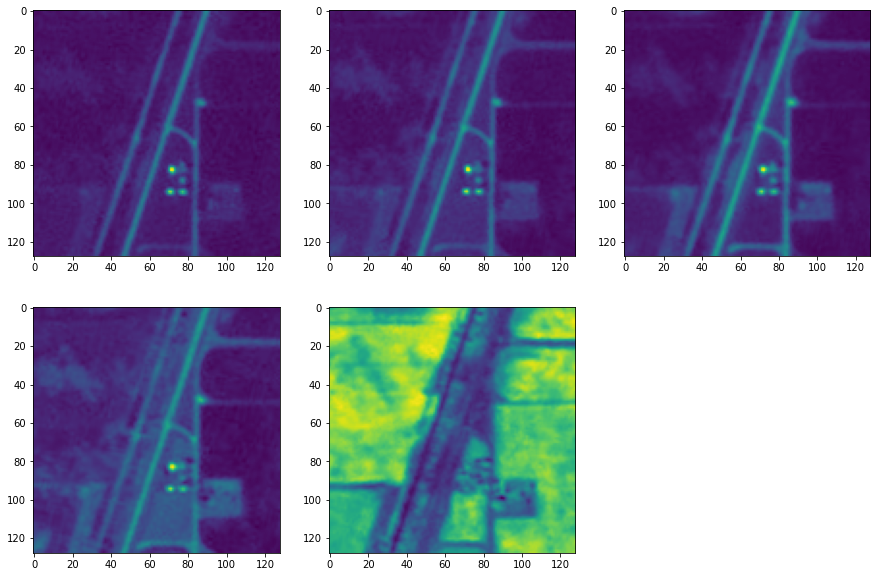

In [21]:
# see original image
pyplot.figure(figsize=(15,10))
for i in range(0,5):
    pyplot.subplot(2,3,i+1)
    pyplot.imshow(x_test[66,...,i])

In [22]:
validation = tiff.imread('20130824_RE3_3A_Analytic_Champaign_south.tif')
print(validation.shape)
# reformat into 128*128
h, w, _ = validation.shape
h = int(h/128)
w = int(w/128)
x_val = validation[:h * 128, :w * 128, :]

x_val = np.reshape(x_val, (h, 128, w, 128, 5))
x_val = np.transpose(x_val, axes=(0,2,1,3,4))
x_val = np.reshape(x_val, (-1, 128, 128, 5))

print(x_val.shape)

(5959, 9425, 5)
(3358, 128, 128, 5)


In [23]:
#model = tf.keras.models.load_model('cleaned_dataset')
y_val = model.predict(x_val)
y_decode = y_val.argmax(axis = 3)

In [24]:
combined = np.zeros((int(5959/128) * 128, int(9425/128) * 128))
x = 0
index = 0
while x < combined.shape[0]:
    y = 0
    while y < combined.shape[1]:
        combined[x:x + 128, y:y + 128] = y_decode[index]
        y += 128
        index += 1
    x += 128
x_val = np.array(x_val)

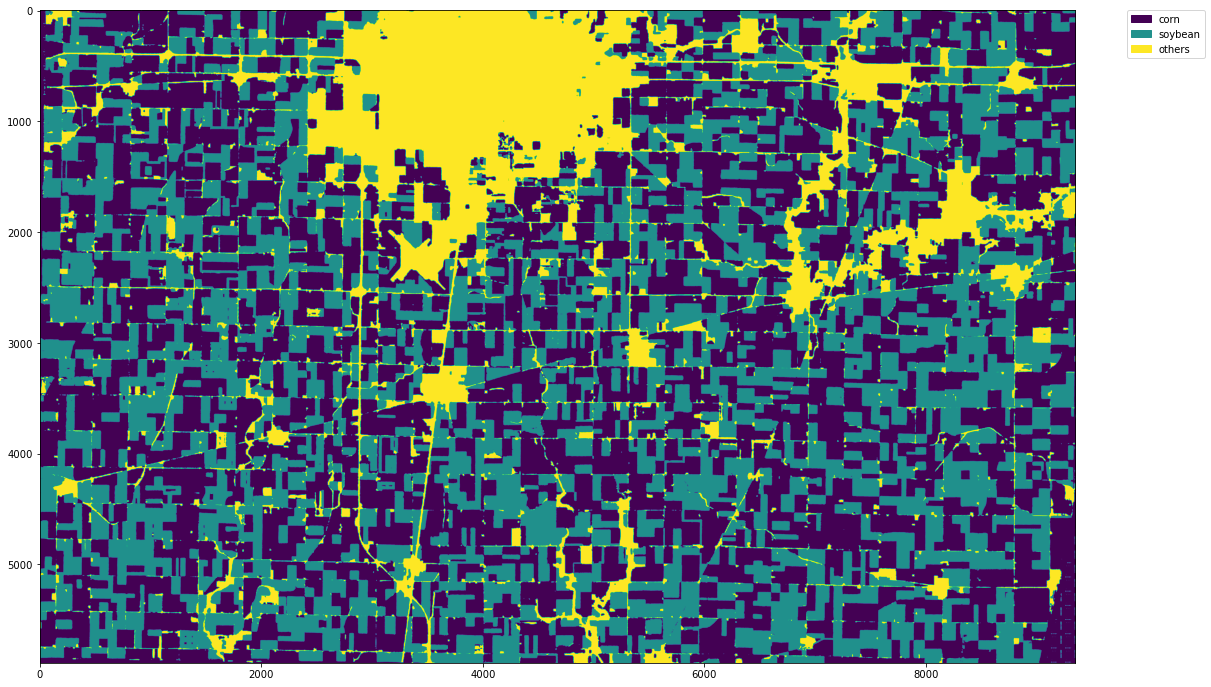

In [25]:
pyplot.figure(figsize = (20, 12))
im = pyplot.imshow(combined)

values = np.unique(combined)
colors = [im.cmap(im.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label=j) for i,j in zip(range(len(values)), ['corn', 'soybean', 'others']) ]
pyplot.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

pyplot.show()

In [26]:
pyplot.imsave('south_unet_with_cleaned_data_2.png', combined)